# Lesson 4: Auto-merging Retrieval

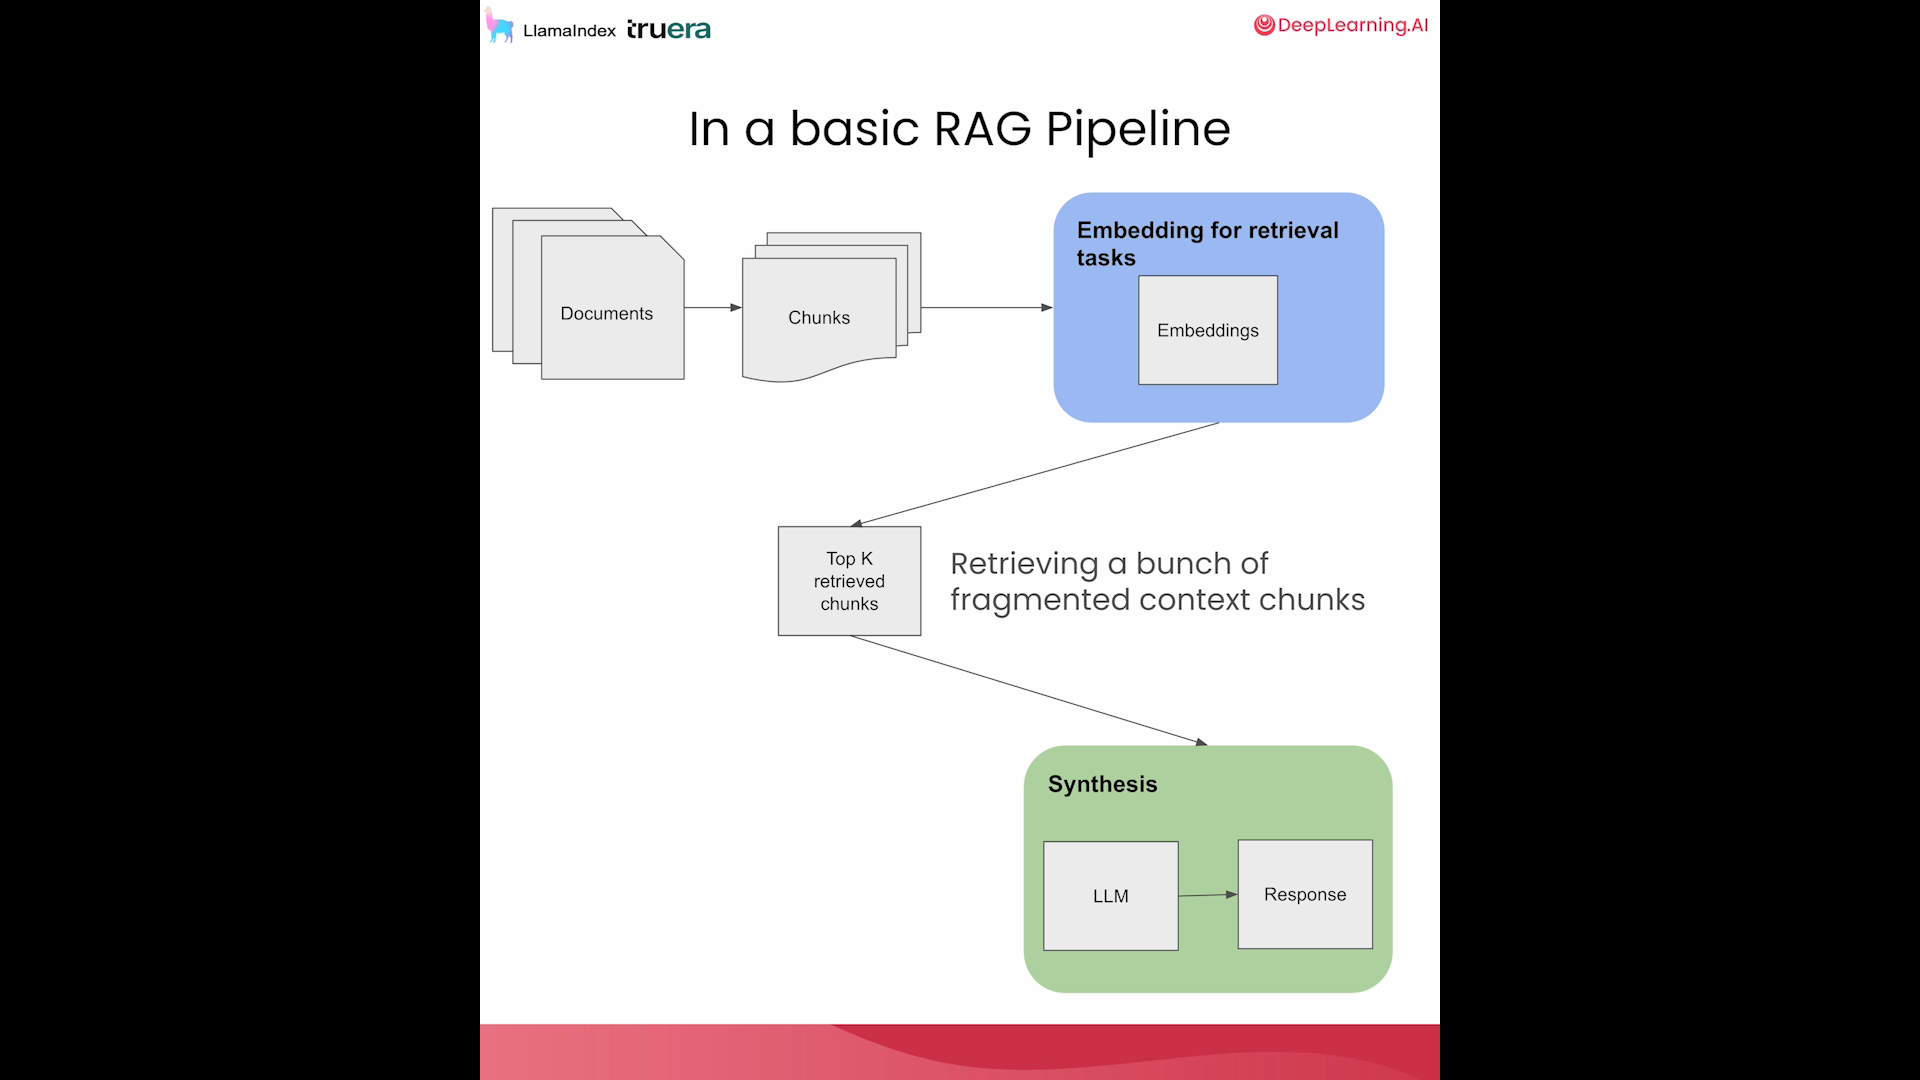

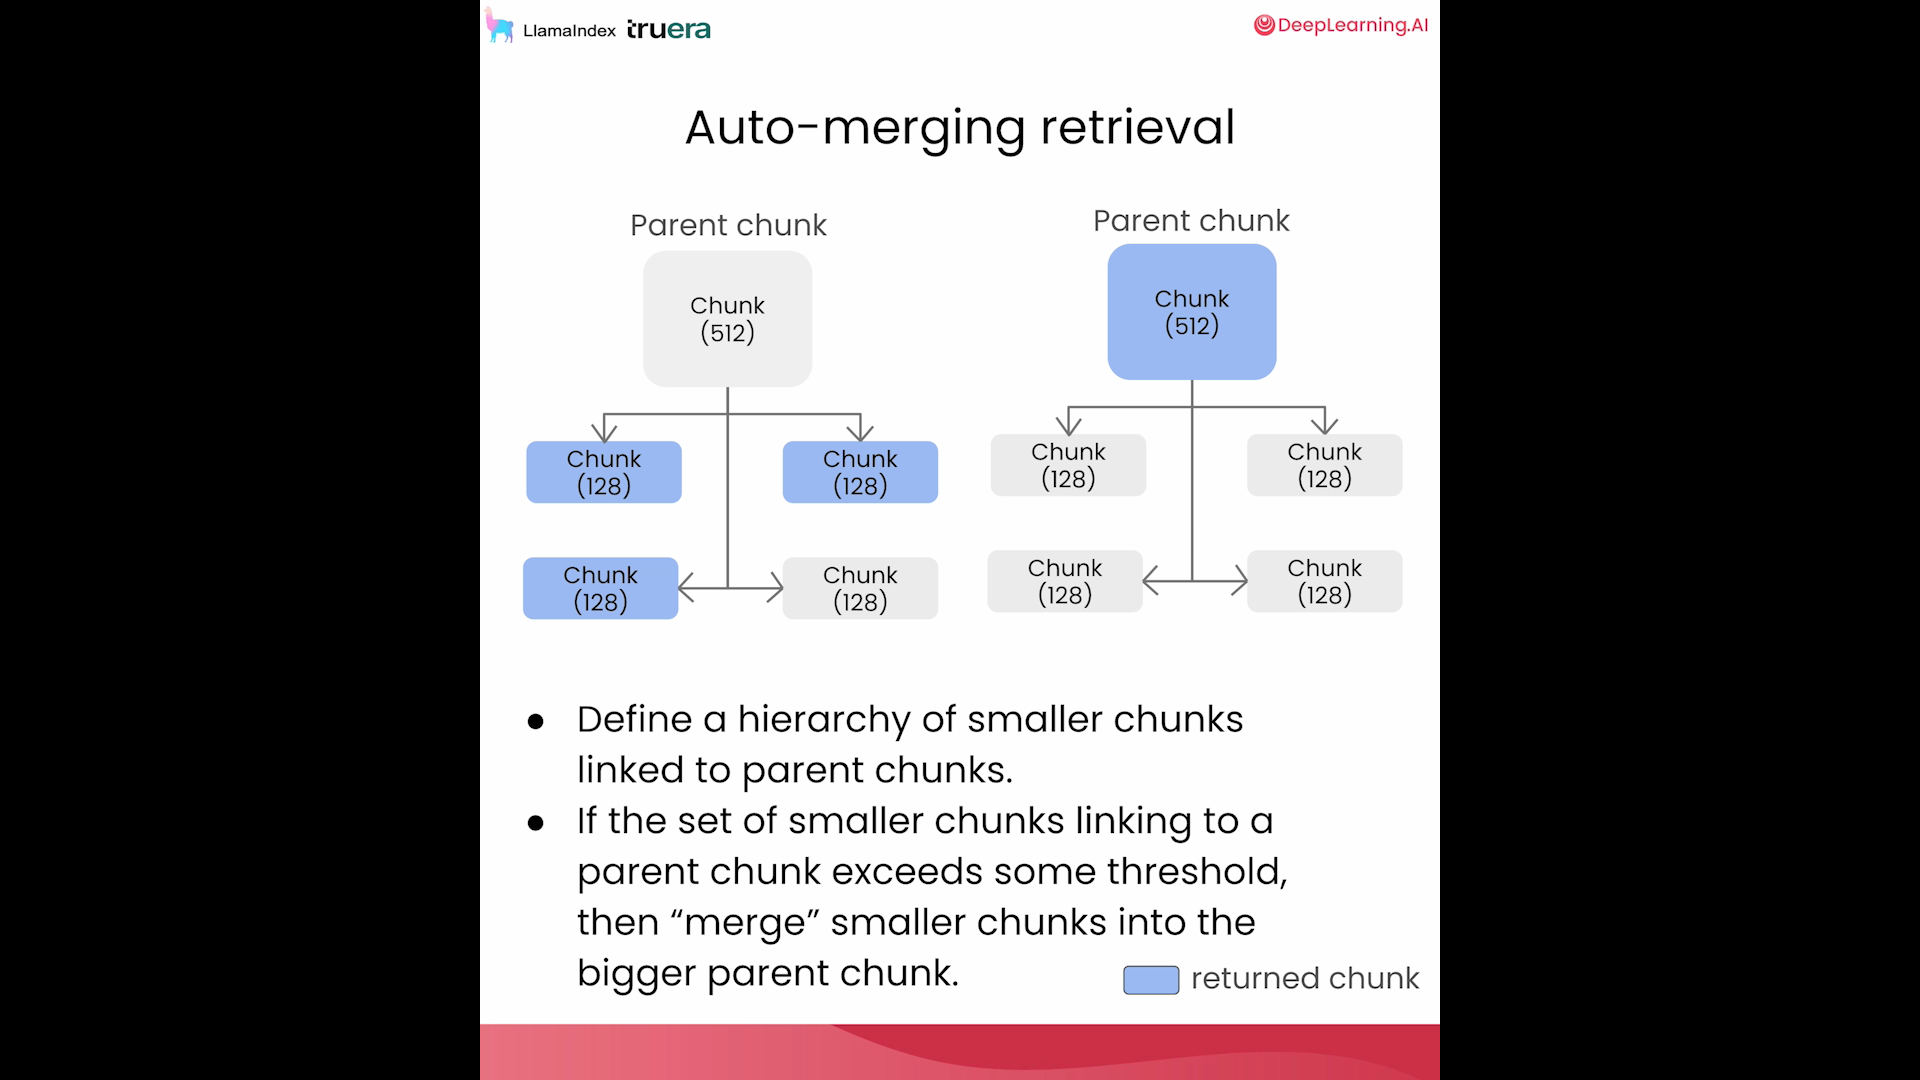

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import utils

import os
import openai
openai.api_key = utils.get_openai_api_key()

In [3]:
from llama_index import SimpleDirectoryReader

documents = SimpleDirectoryReader(
    input_files=["./eBook-How-to-Build-a-Career-in-AI.pdf"]
).load_data()

In [4]:
print(type(documents), "\n")
print(len(documents), "\n")
print(type(documents[0]))
print(documents[0])

<class 'list'> 

41 

<class 'llama_index.schema.Document'>
Doc ID: 075aa737-45de-4aec-940f-5f5193aa07c8
Text: PAGE 1Founder, DeepLearning.AICollected Insights from Andrew Ng
How to  Build Your Career in AIA Simple Guide


## Auto-merging retrieval setup

In [6]:
from llama_index import Document

document = Document(text="\n\n".join([doc.text for doc in documents]))

In [7]:
from llama_index.node_parser import HierarchicalNodeParser

# create the hierarchical node parser w/ default settings
node_parser = HierarchicalNodeParser.from_defaults(
    chunk_sizes=[2048, 512, 128]
)

[nltk_data] Downloading package punkt to /tmp/llama_index...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
nodes = node_parser.get_nodes_from_documents([document])

In [9]:
from llama_index.node_parser import get_leaf_nodes

leaf_nodes = get_leaf_nodes(nodes)
print(leaf_nodes[30].text) ## This is small .because it only has 128 tokens

But this became less important as numerical linear algebra libraries matured.
Deep learning is still an emerging technology, so when you train a neural network and the 
optimization algorithm struggles to converge, understanding the math behind gradient 
descent, momentum, and the Adam  optimization algorithm will help you make better decisions. 
Similarly, if your neural network does something funny — say, it makes bad predictions on 
images of a certain resolution, but not others — understanding the math behind neural network 
architectures puts you in a better position to figure out what to do.
Of course, I also encourage learning driven by curiosity.


In [10]:
nodes_by_id = {node.node_id: node for node in nodes}

parent_node = nodes_by_id[leaf_nodes[30].parent_node.node_id]
print(parent_node.text)

PAGE 12Should You 
Learn Math to 
Get a Job in AI? CHAPTER 3
LEARNING

PAGE 13Should you Learn Math to Get a Job in AI? CHAPTER 3
Is math a foundational skill for AI? It’s always nice to know more math! But there’s so much to 
learn that, realistically, it’s necessary to prioritize. Here’s how you might go about strengthening 
your math background.
To figure out what’s important to know, I find it useful to ask what you need to know to make 
the decisions required for the work you want to do. At DeepLearning.AI, we frequently ask, 
“What does someone need to know to accomplish their goals?” The goal might be building a 
machine learning model, architecting a system, or passing a job interview.
Understanding the math behind algorithms you use is often helpful, since it enables you to 
debug them. But the depth of knowledge that’s useful changes over time. As machine learning 
techniques mature and become more reliable and turnkey, they require less debugging, and a 
shallower understand

### Building the index

In [11]:
from llama_index.llms import OpenAI

llm = OpenAI(model="gpt-3.5-turbo", temperature=0.1)

In [12]:
from llama_index import ServiceContext

auto_merging_context = ServiceContext.from_defaults(
    llm=llm,
    embed_model="local:BAAI/bge-small-en-v1.5",
    node_parser=node_parser,
)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [14]:
from llama_index import VectorStoreIndex, StorageContext

'''
Vector Index - Leaf nodes are indexed . But vector index has some knowledge of docstore as well
Intermediate and Parents nodes - DocStore . And this are retrieved dynamically

'''

storage_context = StorageContext.from_defaults()
storage_context.docstore.add_documents(nodes)

automerging_index = VectorStoreIndex(
    leaf_nodes, storage_context=storage_context, service_context=auto_merging_context
)

automerging_index.storage_context.persist(persist_dir="./merging_index")

In [15]:
# This block of code is optional to check
# if an index file exist, then it will load it
# if not, it will rebuild it

import os
from llama_index import VectorStoreIndex, StorageContext, load_index_from_storage
from llama_index import load_index_from_storage

if not os.path.exists("./merging_index"):
    storage_context = StorageContext.from_defaults()
    storage_context.docstore.add_documents(nodes)

    automerging_index = VectorStoreIndex(
            leaf_nodes,
            storage_context=storage_context,
            service_context=auto_merging_context
        )

    automerging_index.storage_context.persist(persist_dir="./merging_index")
else:
    automerging_index = load_index_from_storage(
        StorageContext.from_defaults(persist_dir="./merging_index"),
        service_context=auto_merging_context
    )


### Defining the retriever and running the query engine

In [16]:
from llama_index.indices.postprocessor import SentenceTransformerRerank
from llama_index.retrievers import AutoMergingRetriever
from llama_index.query_engine import RetrieverQueryEngine

automerging_retriever = automerging_index.as_retriever(
    similarity_top_k=12
)

retriever = AutoMergingRetriever(
    automerging_retriever, 
    automerging_index.storage_context, 
    verbose=True
)

rerank = SentenceTransformerRerank(top_n=6, model="BAAI/bge-reranker-base")

auto_merging_engine = RetrieverQueryEngine.from_args(
    automerging_retriever, node_postprocessors=[rerank]
)

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

In [17]:
auto_merging_response = auto_merging_engine.query(
    "What is the importance of networking in AI?"
)

In [18]:
from llama_index.response.notebook_utils import display_response

display_response(auto_merging_response)

**`Final Response:`** Networking is important in AI because it allows individuals to build a strong professional network and community. This network can provide valuable information, help with career advancement, and offer support and advice when needed. By connecting with others in the AI community, individuals can also increase their visibility and recognition for their expertise. Additionally, networking can lead to referrals for potential job opportunities. Building a community and networking within it can help individuals stay connected, learn from others, and foster collaboration and innovation in the field of AI.

## Putting it all Together

In [19]:
import os

from llama_index import (
    ServiceContext,
    StorageContext,
    VectorStoreIndex,
    load_index_from_storage,
)
from llama_index.node_parser import HierarchicalNodeParser
from llama_index.node_parser import get_leaf_nodes
from llama_index import StorageContext, load_index_from_storage
from llama_index.retrievers import AutoMergingRetriever
from llama_index.indices.postprocessor import SentenceTransformerRerank
from llama_index.query_engine import RetrieverQueryEngine


def build_automerging_index(
    documents,
    llm,
    embed_model="local:BAAI/bge-small-en-v1.5",
    save_dir="merging_index",
    chunk_sizes=None,
):
    chunk_sizes = chunk_sizes or [2048, 512, 128]
    node_parser = HierarchicalNodeParser.from_defaults(chunk_sizes=chunk_sizes)
    nodes = node_parser.get_nodes_from_documents(documents)
    leaf_nodes = get_leaf_nodes(nodes)
    merging_context = ServiceContext.from_defaults(
        llm=llm,
        embed_model=embed_model,
    )
    storage_context = StorageContext.from_defaults()
    storage_context.docstore.add_documents(nodes)

    if not os.path.exists(save_dir):
        automerging_index = VectorStoreIndex(
            leaf_nodes, storage_context=storage_context, service_context=merging_context
        )
        automerging_index.storage_context.persist(persist_dir=save_dir)
    else:
        automerging_index = load_index_from_storage(
            StorageContext.from_defaults(persist_dir=save_dir),
            service_context=merging_context,
        )
    return automerging_index


def get_automerging_query_engine(
    automerging_index,
    similarity_top_k=12,
    rerank_top_n=6,
):
    base_retriever = automerging_index.as_retriever(similarity_top_k=similarity_top_k)
    retriever = AutoMergingRetriever(
        base_retriever, automerging_index.storage_context, verbose=True
    )
    rerank = SentenceTransformerRerank(
        top_n=rerank_top_n, model="BAAI/bge-reranker-base"
    )
    auto_merging_engine = RetrieverQueryEngine.from_args(
        retriever, node_postprocessors=[rerank]
    )
    return auto_merging_engine

In [20]:
from llama_index.llms import OpenAI

index = build_automerging_index(
    [document],
    llm=OpenAI(model="gpt-3.5-turbo", temperature=0.1),
    save_dir="./merging_index",
)


In [21]:
query_engine = get_automerging_query_engine(index, similarity_top_k=6)

## TruLens Evaluation

In [22]:
from trulens_eval import Tru

Tru().reset_database()

🦑 Tru initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `Tru` to prevent this.


### Two layers

In [23]:
auto_merging_index_0 = build_automerging_index(
    documents,
    llm=OpenAI(model="gpt-3.5-turbo", temperature=0.1),
    embed_model="local:BAAI/bge-small-en-v1.5",
    save_dir="merging_index_0",
    chunk_sizes=[2048,512],
)

In [24]:
auto_merging_engine_0 = get_automerging_query_engine(
    auto_merging_index_0,
    similarity_top_k=12,
    rerank_top_n=6,
)

In [25]:
from utils import get_prebuilt_trulens_recorder

tru_recorder = get_prebuilt_trulens_recorder(
    auto_merging_engine_0,
    app_id ='app_0'
)

✅ In Answer Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Answer Relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Context Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Context Relevance, input response will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input source will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .


In [26]:
eval_questions = []
with open('generated_questions.text', 'r') as file:
    for line in file:
        # Remove newline character and convert to integer
        item = line.strip()
        eval_questions.append(item)

In [27]:
def run_evals(eval_questions, tru_recorder, query_engine):
    for question in eval_questions:
        with tru_recorder as recording:
            response = query_engine.query(question)

In [ ]:
run_evals(eval_questions, tru_recorder, auto_merging_engine_0)

> Merging 1 nodes into parent node.
> Parent node id: 2be0dc1a-adcf-441b-b523-103aa8d83a0d.
> Parent node text: PAGE 26If you’re considering a role switch, a startup can be an easier place to do it than a big ...

> Merging 1 nodes into parent node.
> Parent node id: eb63eed2-cd13-4052-8dce-058b5612eaac.
> Parent node text: PAGE 25Finding a job has a few predictable steps that include selecting the companies to which yo...

> Merging 1 nodes into parent node.
> Parent node id: 0a5704f5-7e84-4dde-bcdd-2263835f2597.
> Parent node text: PAGE 33Choose who to work with. It’s tempting to take a position because of the projects you’ll w...

> Merging 1 nodes into parent node.
> Parent node id: 06d58662-f3a8-449e-8ffa-1bb51412ded0.
> Parent node text: PAGE 23Each project is only one step on a longer journey, hopefully one that has a positive impac...

> Merging 1 nodes into parent node.
> Parent node id: efc7a9cf-74a8-4322-8323-981c8fd3d7fb.
> Parent node text: PAGE 29If you’re preparing to sw

In [ ]:
from trulens_eval import Tru

Tru().get_leaderboard(app_ids=[])

In [ ]:
Tru().run_dashboard()

### Three layers

In [ ]:
auto_merging_index_1 = build_automerging_index(
    documents,
    llm=OpenAI(model="gpt-3.5-turbo", temperature=0.1),
    embed_model="local:BAAI/bge-small-en-v1.5",
    save_dir="merging_index_1",
    chunk_sizes=[2048,512,128],
)

In [ ]:
auto_merging_engine_1 = get_automerging_query_engine(
    auto_merging_index_1,
    similarity_top_k=12,
    rerank_top_n=6,
)


In [ ]:
tru_recorder = get_prebuilt_trulens_recorder(
    auto_merging_engine_1,
    app_id ='app_1'
)

In [ ]:
run_evals(eval_questions, tru_recorder, auto_merging_engine_1)

In [ ]:
from trulens_eval import Tru

Tru().get_leaderboard(app_ids=[])

In [ ]:
Tru().run_dashboard()

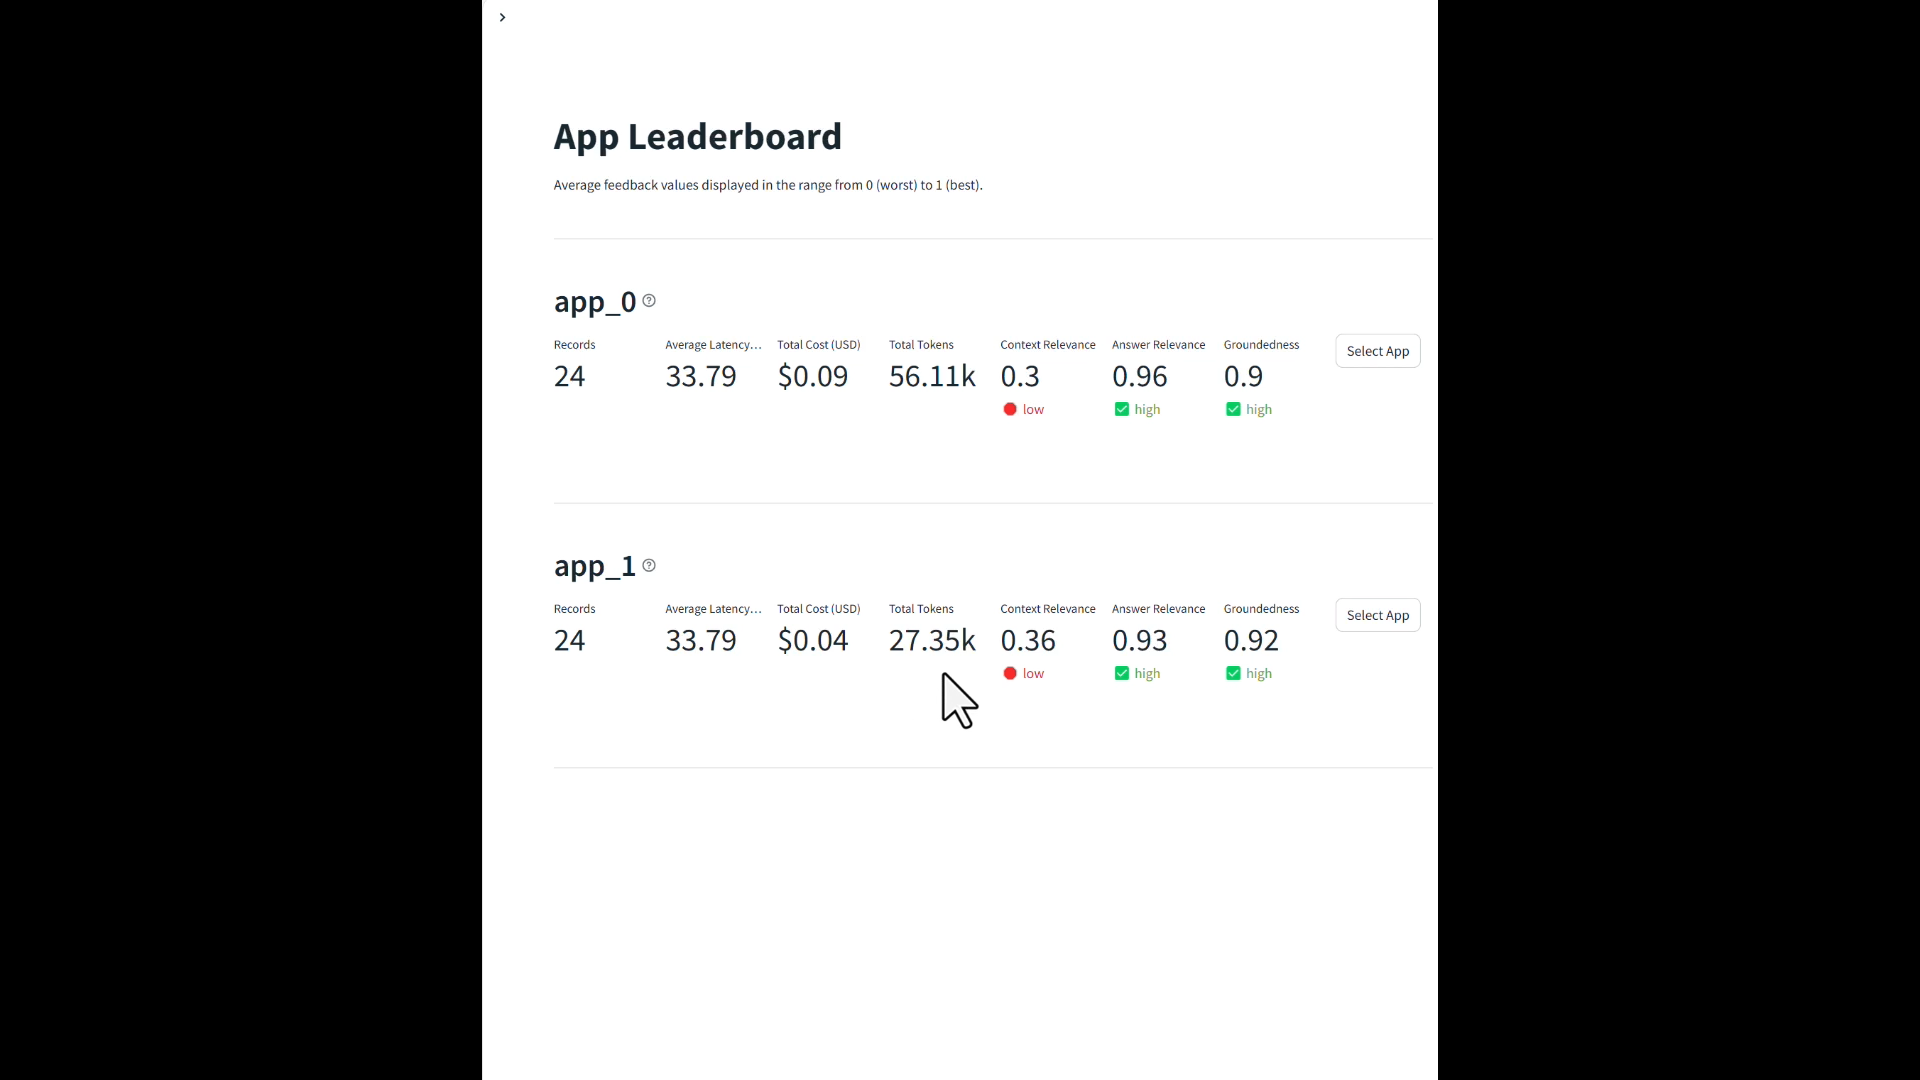

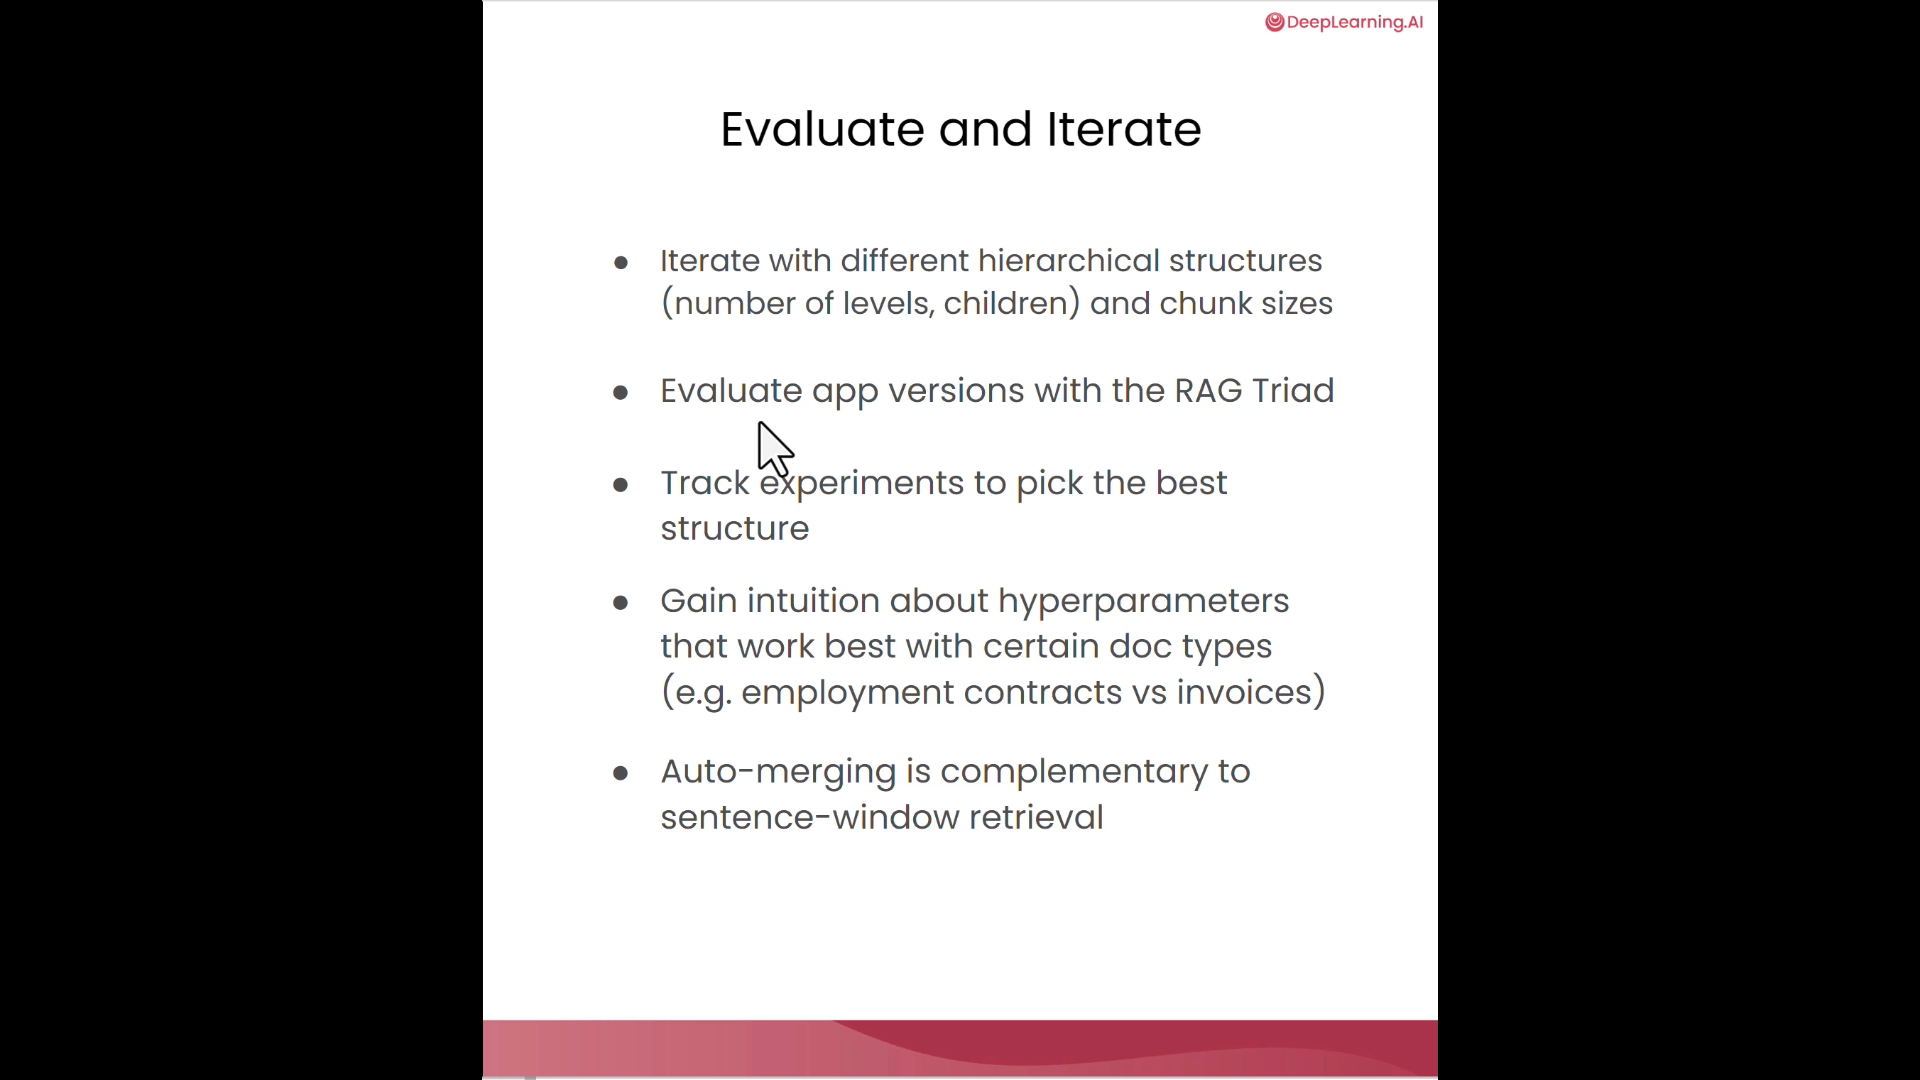

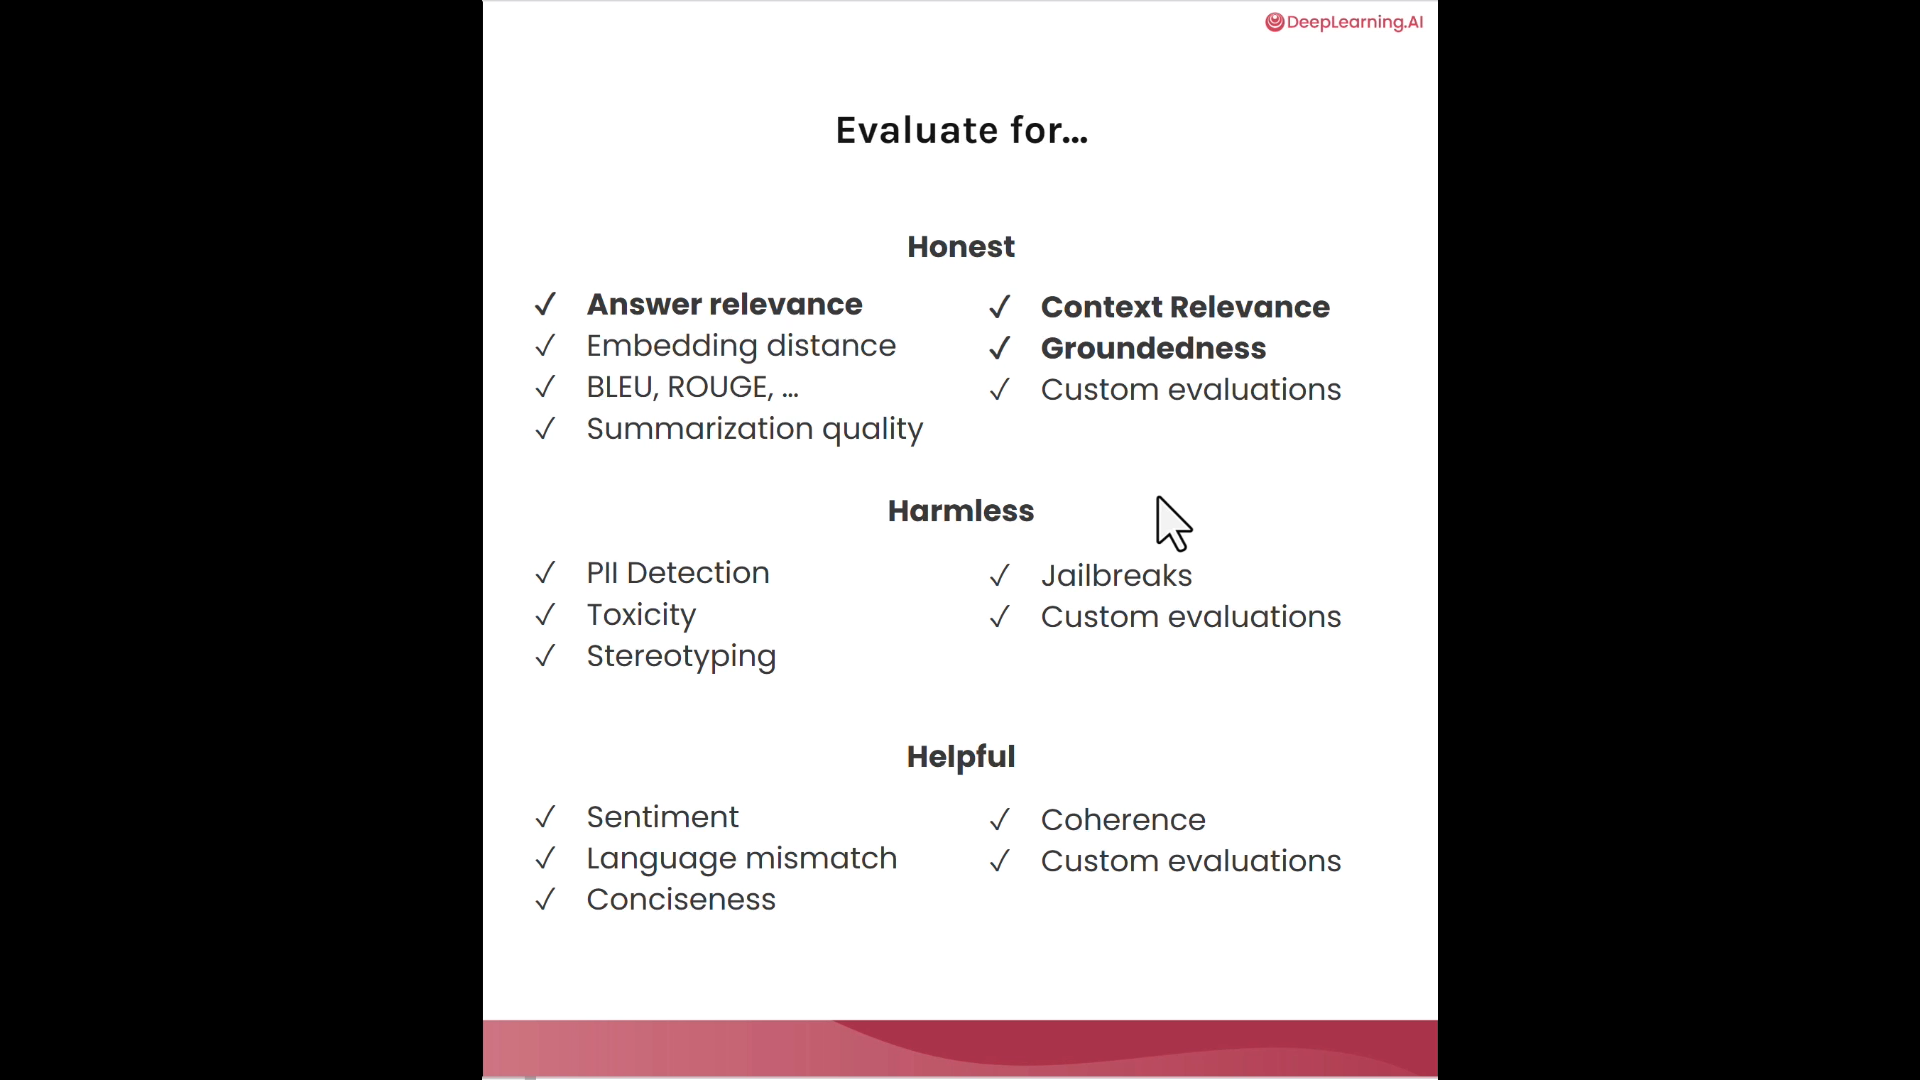